## Analyze Learning Curves

1. Find a comparable checkpoints between two trainings.
    + Either statistically
    + or ...
2. 

In [120]:
import pickle
from scipy import stats
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme();

import numpy as np

from sage.visualization.vistool import plot_vismap
from utils.analysis import Result, FileSelector, check_existence, cherry_picker, transform

In [121]:
with open("./data/naive_results.pkl", "rb") as f:
    naive_results = pickle.load(f)
    naive_results = {e[0]: e[1] for e in sorted(naive_results.items(), key=lambda x: x[0])}
    
with open("./data/augment_results.pkl", "rb") as f:
    augment_results = pickle.load(f)
    augment_results = {e[0]: e[1] for e in sorted(augment_results.items(), key=lambda x: x[0])}

In [122]:
naive = Result(naive_results)
augment = Result(augment_results)

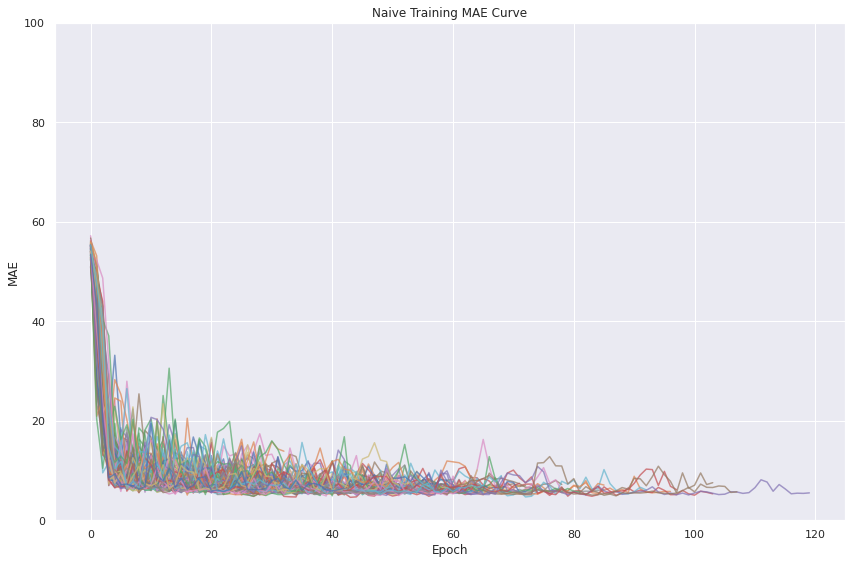

In [123]:
plt.figure(figsize=(12, 8))
plt.title("Naive Training MAE Curve")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.ylim(0, 100)

for idx in range(len(naive)):
    plt.plot(*transform(naive[idx]), alpha=.7)

plt.show();

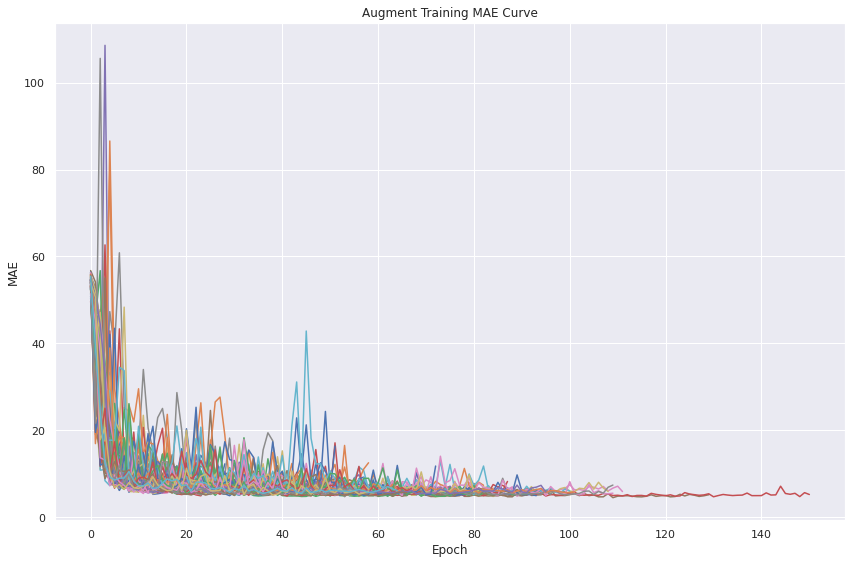

In [124]:
plt.figure(figsize=(12, 8))
plt.title("Augment Training MAE Curve")
plt.xlabel("Epoch")
plt.ylabel("MAE")

for idx in range(len(augment)):
    plt.plot(*transform(augment[idx]))

plt.show();

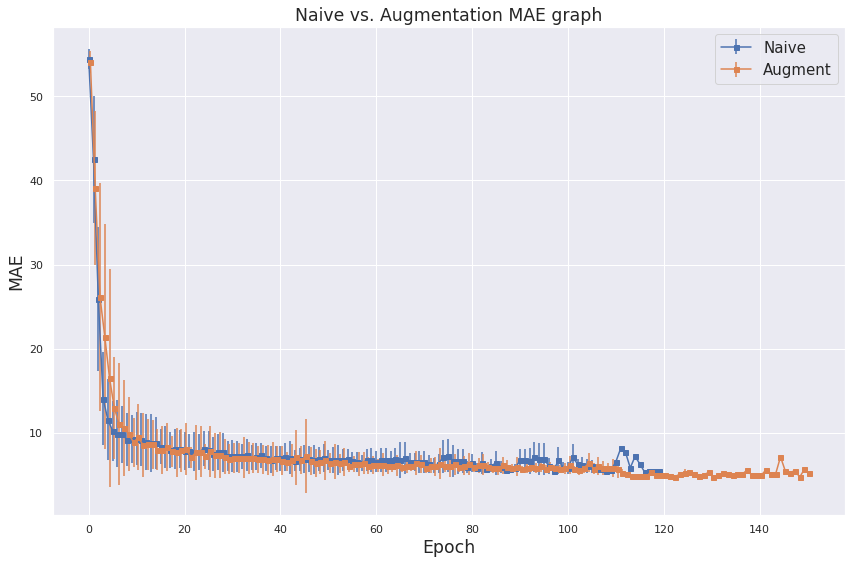

In [125]:
plt.figure(figsize=(12, 8))
plt.title("Naive vs. Augmentation MAE graph", size="x-large")
plt.xlabel("Epoch", size="x-large")
plt.ylabel("MAE", size="x-large")
plt.errorbar(
    *map(list, (naive.mean.keys(), naive.mean.values())), ms=5, marker='s',
    yerr=list(naive.std.values()), label="Naive"
);
plt.errorbar(
    np.array(list(augment.mean.keys())) + .35, list(augment.mean.values()), ms=5, marker='s',
    yerr=list(augment.std.values()), label="Augment"
);
plt.legend(prop={"size": 15})

In [56]:
last_values_naive = [e[-1][1] for e in naive.raw_data.values()]
last_values_augment = [e[-1][1] for e in augment.raw_data.values()]

stats.ttest_ind(last_values_naive, last_values_augment)

Ttest_indResult(statistic=1.0990587789525672, pvalue=0.2730703078217951)

In [57]:
best_values_naive = [min(_[1] for _ in e) for e in naive.raw_data.values()]
best_values_augment = [min(_[1] for _ in e) for e in augment.raw_data.values()]

stats.ttest_ind(best_values_naive, best_values_augment)

Ttest_indResult(statistic=2.879221535304477, pvalue=0.004422656227491631)

In [58]:
earlystopped_values_naive = [e[-20][1] for e in naive.raw_data.values()]
earlystopped_values_augment = [e[-20][1] for e in augment.raw_data.values()]

stats.ttest_ind(earlystopped_values_naive, earlystopped_values_augment)

Ttest_indResult(statistic=-0.2240422043460316, pvalue=0.8229543123500607)

In [61]:
total_train_naive = [len(e) for e in naive.raw_data.values()]
total_train_augment = [len(e) for e in augment.raw_data.values()]

stats.ttest_ind(total_train_naive, total_train_augment)

Ttest_indResult(statistic=-4.5232628815038405, pvalue=1.0454025106861184e-05)

In [62]:
best_indices_naive = [sorted(e, key=lambda x: x[1])[0][0] for e in naive.raw_data.values()]
best_indices_augment = [sorted(e, key=lambda x: x[1])[0][0] for e in augment.raw_data.values()]

stats.ttest_ind(best_indices_naive, best_indices_augment)

Ttest_indResult(statistic=-4.595285554815261, pvalue=7.664566425511195e-06)

In [113]:
naive_fileselector = FileSelector("naive")
best_maps_naive = np.array(list(map(
    partial(cherry_picker, selector=naive_fileselector), 
    list(filter(\
        partial(check_existence, selector=naive_fileselector), \
        zip(range(len(best_indices_naive)), best_indices_naive))
))))

In [114]:
augment_fileselector = FileSelector("augment")
best_maps_augment = np.array(list(map(
    partial(cherry_picker, selector=augment_fileselector), 
    list(filter(\
        partial(check_existence, selector=augment_fileselector), \
        zip(range(len(best_indices_augment)), best_indices_augment))
))))

33 130


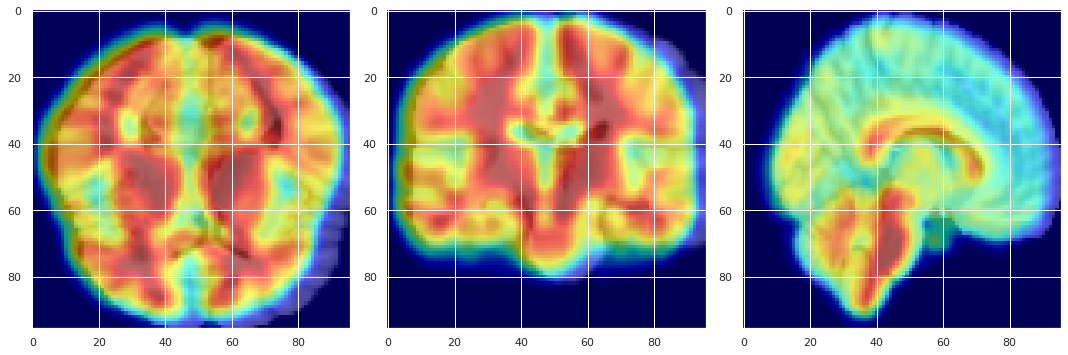

In [115]:
plot_vismap("template", np.mean(best_maps_naive, axis=0), masked=False);

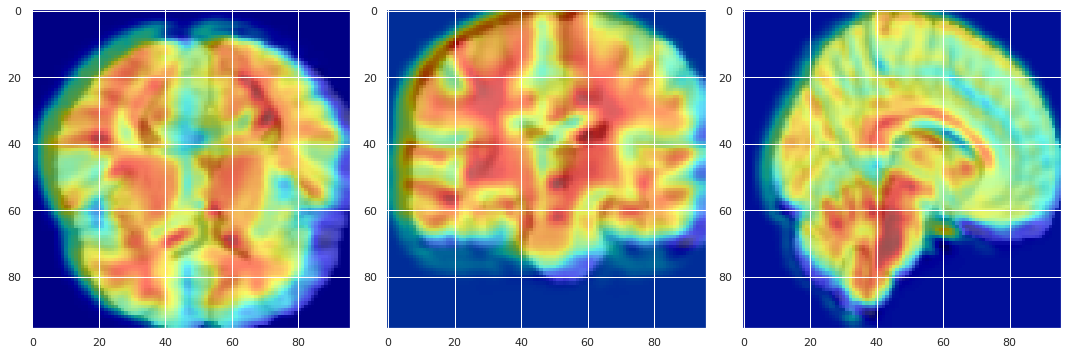

In [126]:
plot_vismap("template", np.mean(best_maps_augment, axis=0), masked=False);